## Antonio Payar Sánchez


---



El objetivo de este trabajo es la exploración de las Redes Generativas. Para ello, qué mejor que empezar por los modelos fundacionales, como son los GAN y One Piece.

El objetivo de este trabajo es la creación de caras similares a las de Eiichirō Oda en One Piece. Para ello, utilizaré un conjunto de datos que encontré en Hugging Face.

https://huggingface.co/datasets/polytechXhf/onepiece-dataset

Uno de los principales problemas que tuve con este conjunto de datos es que gran parte de las imágenes son de cuerpo entero, con diferentes fondos, y muchas de ellas en blanco y negro. Dado que quiero que la red neuronal se enfoque en imitar las caras, me vi en la necesidad de aplicar un detector de rostros para quedarme únicamente con esa información relevante.

https://huggingface.co/arnabdhar/YOLOv8-Face-Detection

Fuente en la que me apoye a la hora de trabajar:

https://www.youtube.com/watch?v=AALBGpLbj6Q

https://github.com/eriklindernoren/Keras-GAN

https://arxiv.org/abs/1511.06434

Finalmente, los resultados después de entrenar la red durante unas 20 horas son los siguientes.

Es comprensible que dada la gran cantidad y variedad de caras que tienen los personajes de One Piece le haya sido complicado generalizar una forma concreta. Dado que en el anime hay personajes desde con forma, humana, animal e incluso otros de dudoso origen.

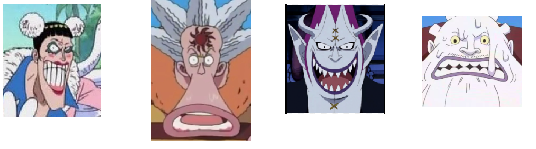

Lo interesante y con lo que me quedo es que dado el poco tiempo de entreno y lo variopintas de caras, la calidad de las mismas.

El modelo consiguió por lo menos generar los que es un esbozo de los que son unos rasgos comunes como puede ser la boca, ojos incluso nariz y pelo.

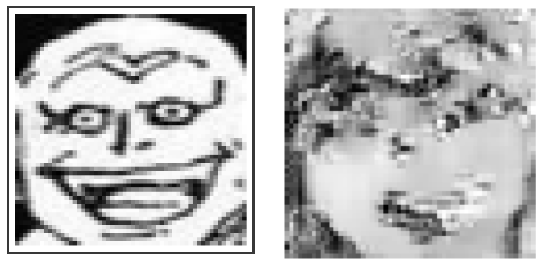

In [ ]:
!pip install datasets;
!pip install ultralytics;
!pip install supervision;

from datasets import load_dataset
import matplotlib.pyplot as plt
import torch
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections
import cv2
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 7.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_6

In [ ]:
# download data
dataset = load_dataset("polytechXhf/onepiece-dataset")

# download model
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


Generating train split:   0%|          | 0/922 [00:00<?, ? examples/s]

model.pt:   0%|          | 0.00/6.25M [00:00<?, ?B/s]

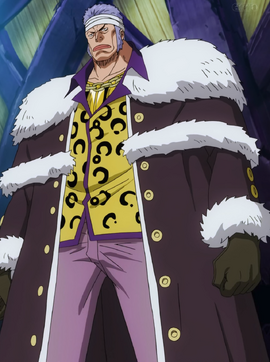

In [ ]:
dataset["train"][np.random.randint(0, 922)]["image"]

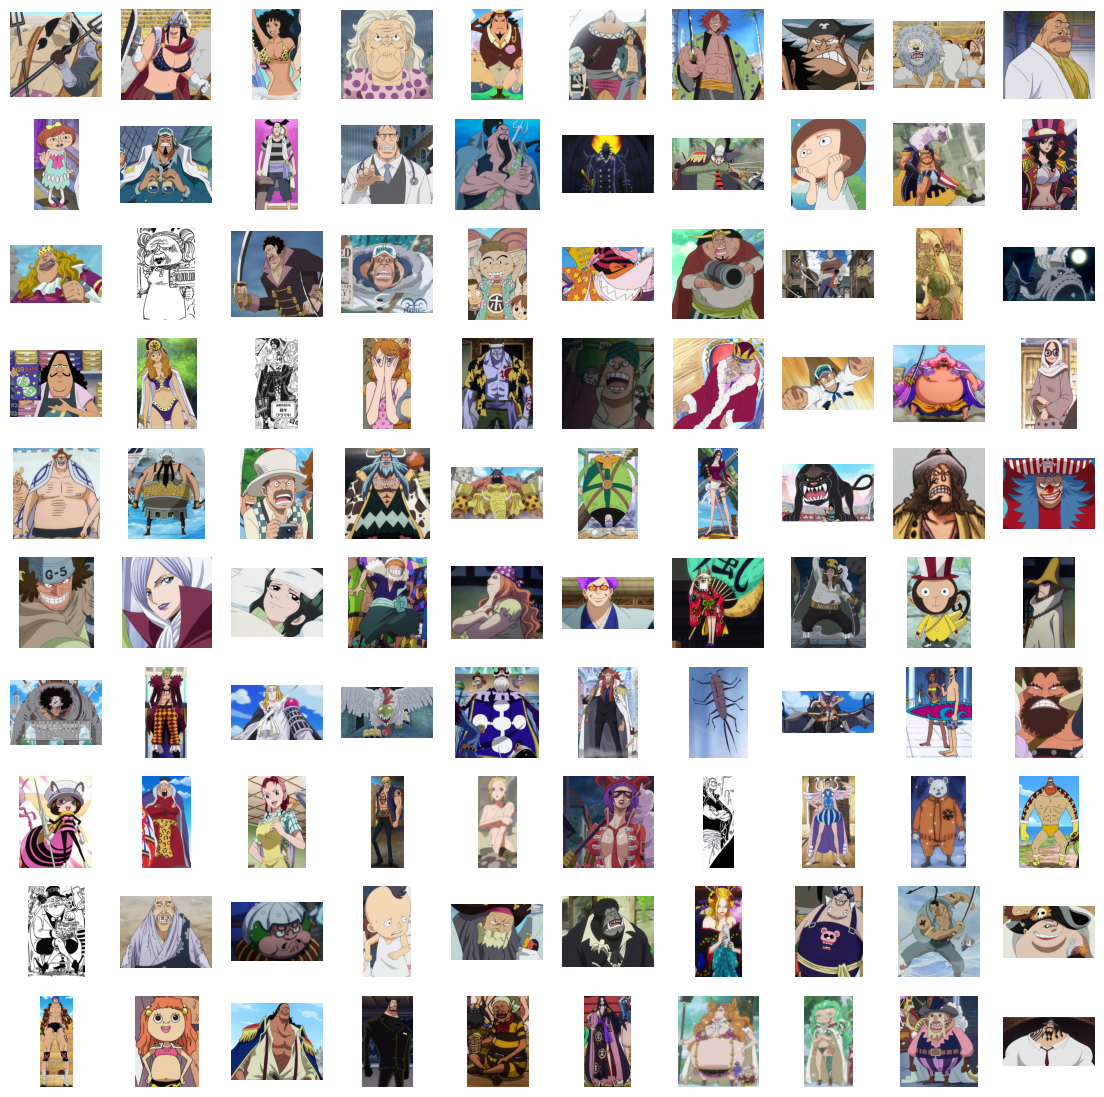

In [ ]:
# Obtener las primeras 100 imágenes del conjunto de entrenamiento
primeras_100_imagenes = dataset["train"][:100]["image"]

# Crear un subplot para mostrar las imágenes
plt.figure(figsize=(14, 14))  # Ajusta el tamaño del gráfico según tus necesidades
for i in range(100):
    plt.subplot(10, 10, i + 1)  # 10 filas, 10 columnas
    plt.imshow(primeras_100_imagenes[i], cmap='gray')  # Ajusta el cmap según tus necesidades
    plt.axis("off")  # Desactiva los ejes para una mejor visualización

plt.show()


# DC-GAN

In [ ]:
from keras.layers import UpSampling2D, Conv2D
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [ ]:
def obtencion_rostros(array_len,dataset):
  df_rostros = []

  for i in range(0, array_len):
    img=dataset["train"][i]["image"].convert('L')

    # Convertir la imagen PIL a una matriz numpy
    image_np = np.array(img)

    # Convertir la imagen a formato RGB (face_recognition espera imágenes en RGB)
    image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

    # load model
    model = YOLO(model_path)

    # Inference
    output = model(image_rgb)
    results = Detections.from_ultralytics(output[0])

    # Acceder al atributo xyxy
    xyxy = results.xyxy

    # Recorrer todas las detecciones en el array xyxy
    for i, (x_min, y_min, x_max, y_max) in enumerate(xyxy):
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])  # Convertir a enteros

        # Extraer la región de interés (ROI)
        roi = image_rgb[y_min:y_max, x_min:x_max]

        # Calcular area
        alto, ancho = roi.shape[:2]
        # Calcular el área (ancho x alto)
        area = ancho * alto

        if area >= 2500:
          df_rostros.append(roi)

  return df_rostros

def preprocess_image(image_list, size):
  resized_and_normalized_images = []

  for image in image_list:

    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Redimensionar la imagen
    resized_image = cv2.resize(gray_image, (size, size))

    # Convertir la imagen a un array de numpy y normalizar
    image_array = resized_image / 127.5 - 1.0

    # Asegurarse de que la imagen tiene la forma correcta (size, size, 1)
    image_array = np.expand_dims(image_array, -1)

    resized_and_normalized_images.append(image_array)

  return resized_and_normalized_images


In [ ]:
df_rostros = obtencion_rostros(920,dataset)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

0: 608x640 (no detections), 111.9ms
Speed: 14.2ms preprocess, 111.9ms inference, 1201.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x640 (no detections), 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x352 1 FACE, 99.8ms
Speed: 2.2ms preprocess, 99.8ms inference, 967.1ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 1 FACE, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 (no detections), 122.8ms
Speed: 2.0ms preprocess, 122.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)



0: 640x544 3 FACEs, 60.4ms
Speed: 2.0ms preprocess, 60.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 FACE, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 (no detections), 63.1ms
Speed: 1.8ms preprocess, 63.1ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 (no detections), 60.4ms
Speed: 1.7ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 (no detections), 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x320 (no detections), 61.8ms
Speed: 1.5ms preprocess, 61.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)

0: 544x640 1 FACE, 62.9ms
Speed: 2.0ms preprocess, 62.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 640x320 1 FACE, 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 1.3ms postprocess per image at 

Rostro 0:


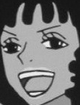

Rostro 1:


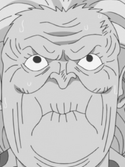

Rostro 2:


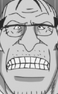

Rostro 3:


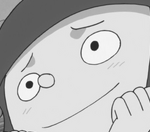

Rostro 4:


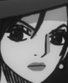

Rostro 5:


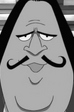

Rostro 6:


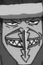

Rostro 7:


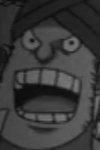

Rostro 8:


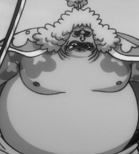

Rostro 9:


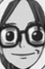

Rostro 10:


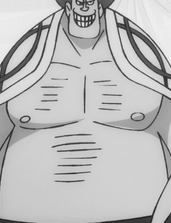

Rostro 11:


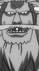

Rostro 12:


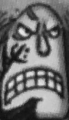

Rostro 13:


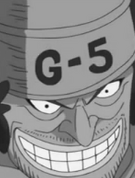

Rostro 14:


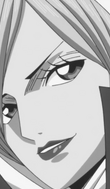

Rostro 15:


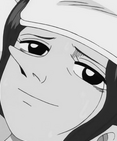

Rostro 16:


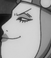

Rostro 17:


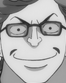

Rostro 18:


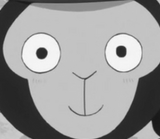

Rostro 19:


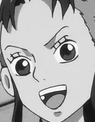

Rostro 20:


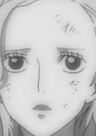

Rostro 21:


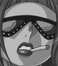

Rostro 22:


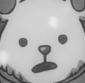

Rostro 23:


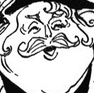

Rostro 24:


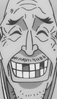

Rostro 25:


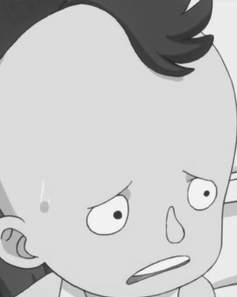

Rostro 26:


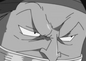

Rostro 27:


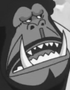

Rostro 28:


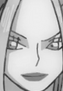

Rostro 29:


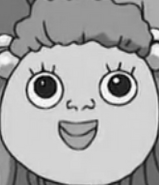

Rostro 30:


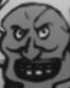

Rostro 31:


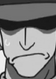

Rostro 32:


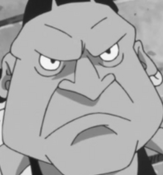

Rostro 33:


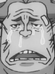

Rostro 34:


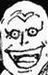

Rostro 35:


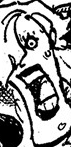

Rostro 36:


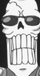

Rostro 37:


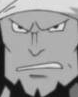

Rostro 38:


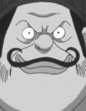

Rostro 39:


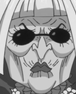

Rostro 40:


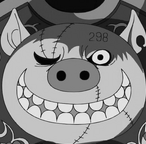

Rostro 41:


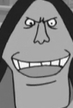

Rostro 42:


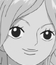

Rostro 43:


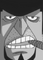

Rostro 44:


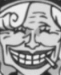

Rostro 45:


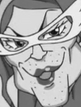

Rostro 46:


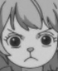

Rostro 47:


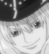

Rostro 48:


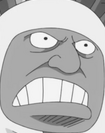

Rostro 49:


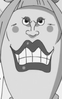

Rostro 50:


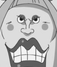

Rostro 51:


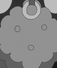

Rostro 52:


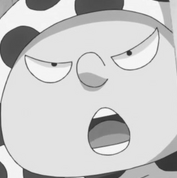

Rostro 53:


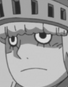

Rostro 54:


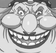

Rostro 55:


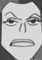

Rostro 56:


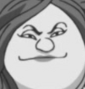

Rostro 57:


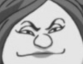

Rostro 58:


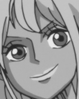

Rostro 59:


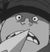

Rostro 60:


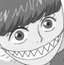

Rostro 61:


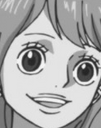

Rostro 62:


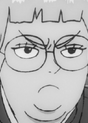

Rostro 63:


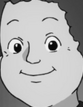

Rostro 64:


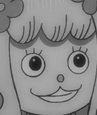

Rostro 65:


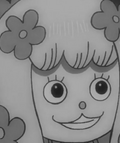

Rostro 66:


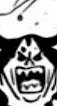

Rostro 67:


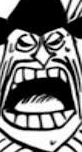

Rostro 68:


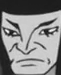

Rostro 69:


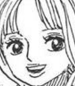

Rostro 70:


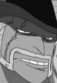

Rostro 71:


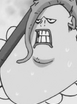

Rostro 72:


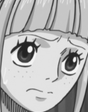

Rostro 73:


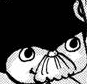

Rostro 74:


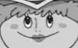

Rostro 75:


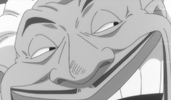

Rostro 76:


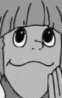

Rostro 77:


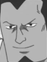

Rostro 78:


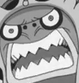

Rostro 79:


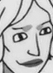

Rostro 80:


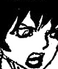

Rostro 81:


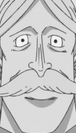

Rostro 82:


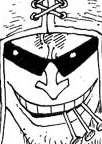

Rostro 83:


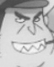

Rostro 84:


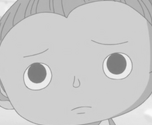

Rostro 85:


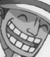

Rostro 86:


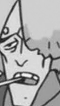

Rostro 87:


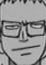

Rostro 88:


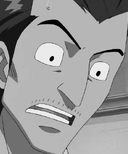

Rostro 89:


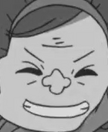

Rostro 90:


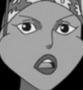

Rostro 91:


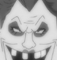

Rostro 92:


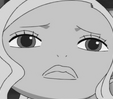

Rostro 93:


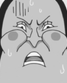

Rostro 94:


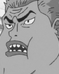

Rostro 95:


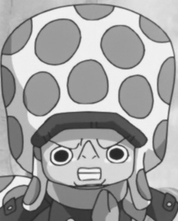

Rostro 96:


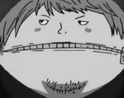

Rostro 97:


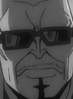

Rostro 98:


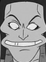

Rostro 99:


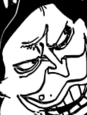

Rostro 100:


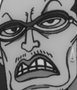

Rostro 101:


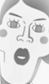

Rostro 102:


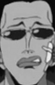

Rostro 103:


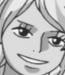

Rostro 104:


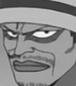

Rostro 105:


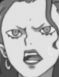

Rostro 106:


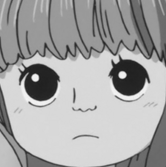

Rostro 107:


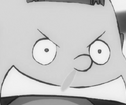

Rostro 108:


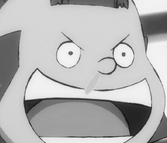

Rostro 109:


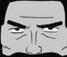

Rostro 110:


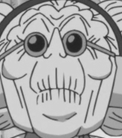

Rostro 111:


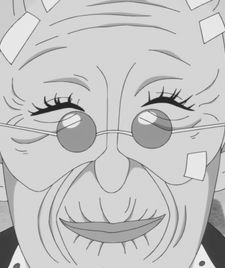

Rostro 112:


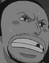

Rostro 113:


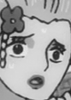

Rostro 114:


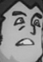

Rostro 115:


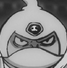

Rostro 116:


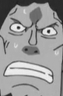

Rostro 117:


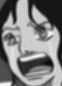

Rostro 118:


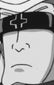

Rostro 119:


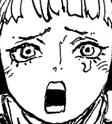

Rostro 120:


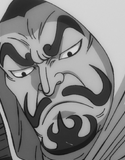

Rostro 121:


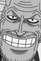

Rostro 122:


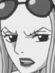

Rostro 123:


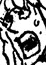

Rostro 124:


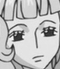

Rostro 125:


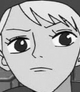

Rostro 126:


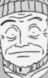

Rostro 127:


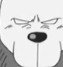

Rostro 128:


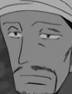

Rostro 129:


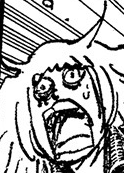

Rostro 130:


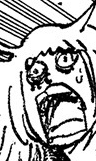

Rostro 131:


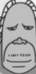

Rostro 132:


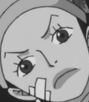

Rostro 133:


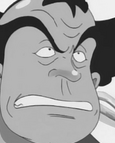

Rostro 134:


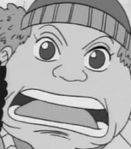

Rostro 135:


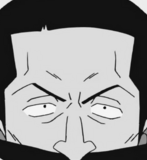

Rostro 136:


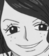

Rostro 137:


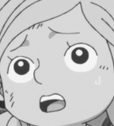

Rostro 138:


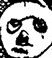

Rostro 139:


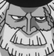

Rostro 140:


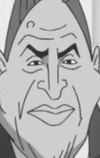

Rostro 141:


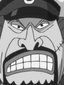

Rostro 142:


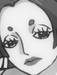

Rostro 143:


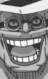

Rostro 144:


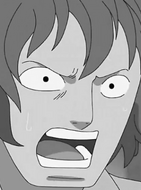

Rostro 145:


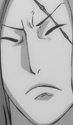

Rostro 146:


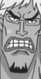

Rostro 147:


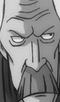

Rostro 148:


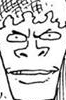

Rostro 149:


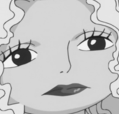

Rostro 150:


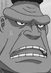

Rostro 151:


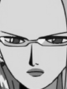

Rostro 152:


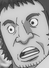

Rostro 153:


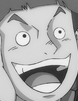

Rostro 154:


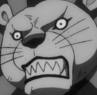

Rostro 155:


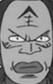

Rostro 156:


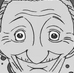

Rostro 157:


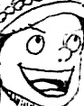

Rostro 158:


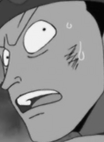

Rostro 159:


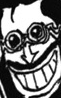

Rostro 160:


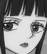

Rostro 161:


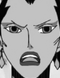

Rostro 162:


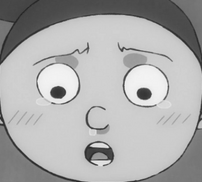

Rostro 163:


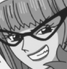

Rostro 164:


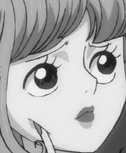

Rostro 165:


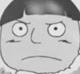

Rostro 166:


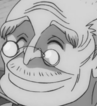

Rostro 167:


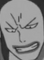

Rostro 168:


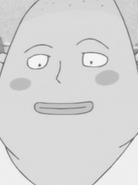

Rostro 169:


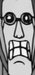

Rostro 170:


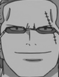

Rostro 171:


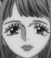

Rostro 172:


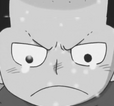

Rostro 173:


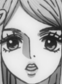

Rostro 174:


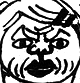

Rostro 175:


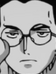

Rostro 176:


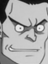

Rostro 177:


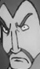

Rostro 178:


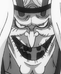

Rostro 179:


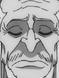

Rostro 180:


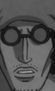

Rostro 181:


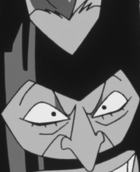

Rostro 182:


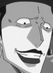

Rostro 183:


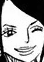

Rostro 184:


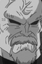

Rostro 185:


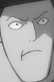

Rostro 186:


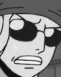

Rostro 187:


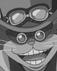

Rostro 188:


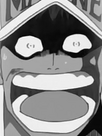

Rostro 189:


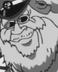

Rostro 190:


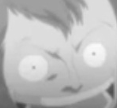

Rostro 191:


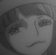

Rostro 192:


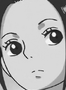

Rostro 193:


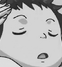

Rostro 194:


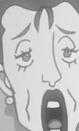

Rostro 195:


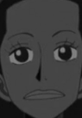

Rostro 196:


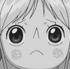

Rostro 197:


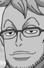

Rostro 198:


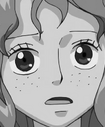

Rostro 199:


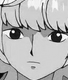

Rostro 200:


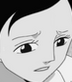

Rostro 201:


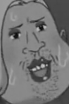

Rostro 202:


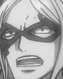

Rostro 203:


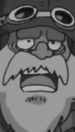

Rostro 204:


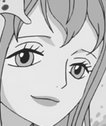

Rostro 205:


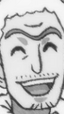

Rostro 206:


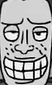

Rostro 207:


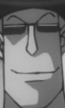

Rostro 208:


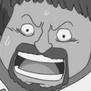

Rostro 209:


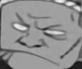

Rostro 210:


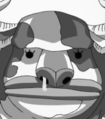

Rostro 211:


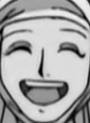

Rostro 212:


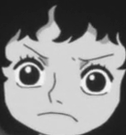

Rostro 213:


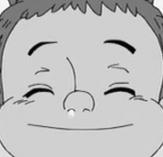

Rostro 214:


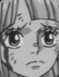

Rostro 215:


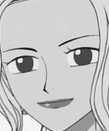

Rostro 216:


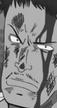

Rostro 217:


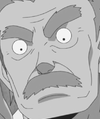

Rostro 218:


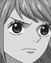

Rostro 219:


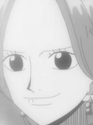

Rostro 220:


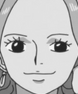

Rostro 221:


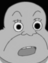

Rostro 222:


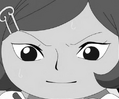

Rostro 223:


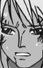

Rostro 224:


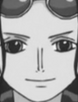

Rostro 225:


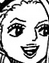

Rostro 226:


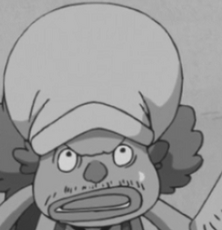

Rostro 227:


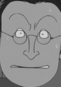

Rostro 228:


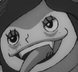

Rostro 229:


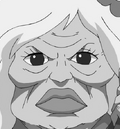

Rostro 230:


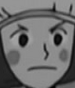

Rostro 231:


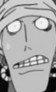

Rostro 232:


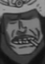

Rostro 233:


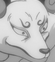

Rostro 234:


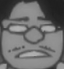

Rostro 235:


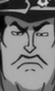

Rostro 236:


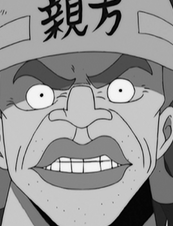

Rostro 237:


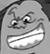

Rostro 238:


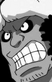

Rostro 239:


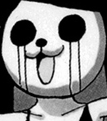

Rostro 240:


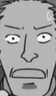

Rostro 241:


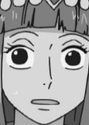

Rostro 242:


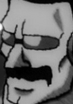

Rostro 243:


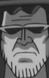

Rostro 244:


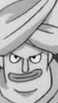

Rostro 245:


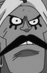

Rostro 246:


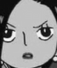

Rostro 247:


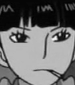

Rostro 248:


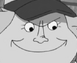

Rostro 249:


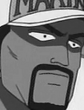

Rostro 250:


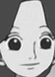

Rostro 251:


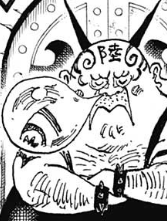

Rostro 252:


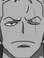

Rostro 253:


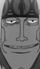

Rostro 254:


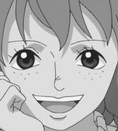

Rostro 255:


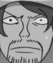

Rostro 256:


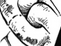

Rostro 257:


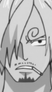

Rostro 258:


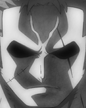

Rostro 259:


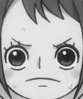

In [ ]:
for i, roi in enumerate(df_rostros):
    print(f"Rostro {i}:")
    cv2_imshow(roi)

In [ ]:
lista_eliminar =[272,265,264,260,255,256,221,212,166,164,136,135,127,98,20,6]

# Eliminar elementos en orden inverso de las posiciones especificadas
for pos in sorted(lista_eliminar, reverse=True):
    del df_rostros[pos]

In [ ]:
df_preprocesado= preprocess_image(df_rostros,56)

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


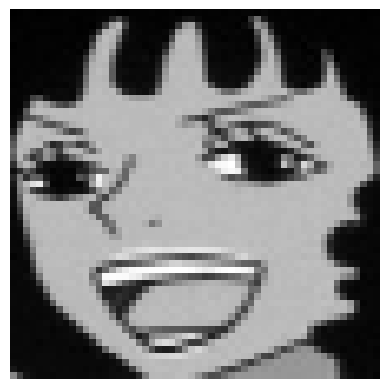

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


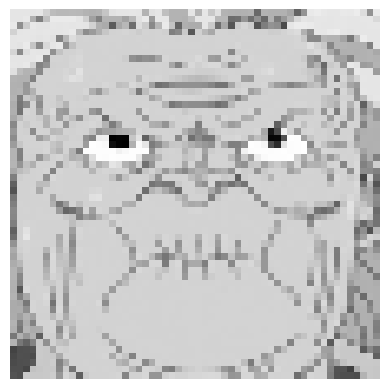

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


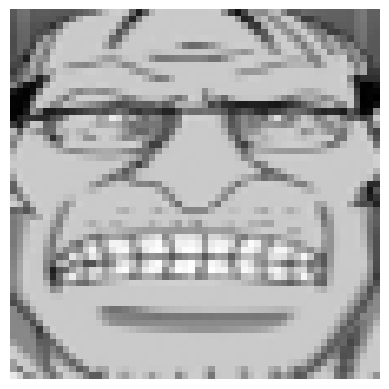

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


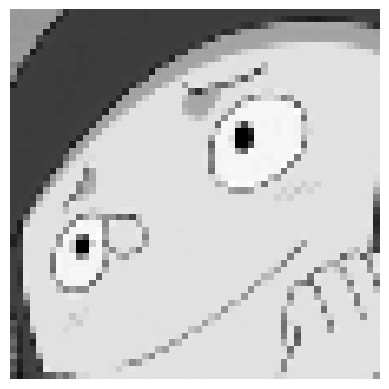

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


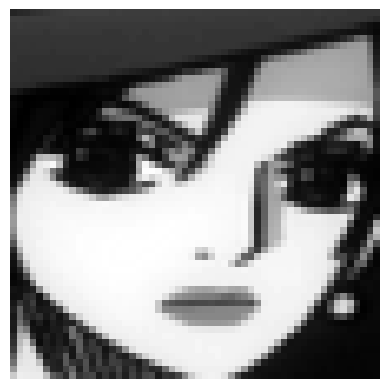

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


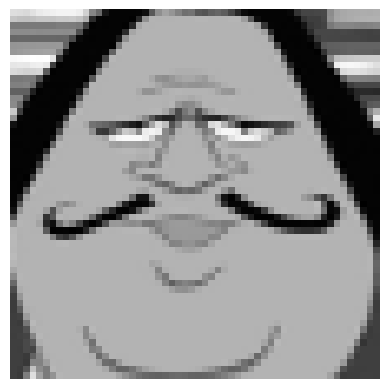

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


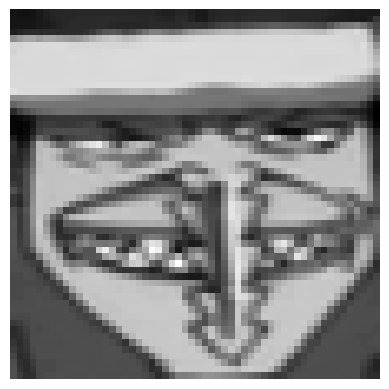

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


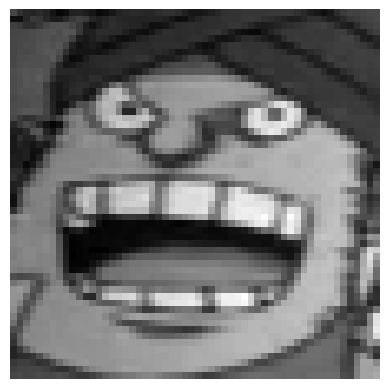

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


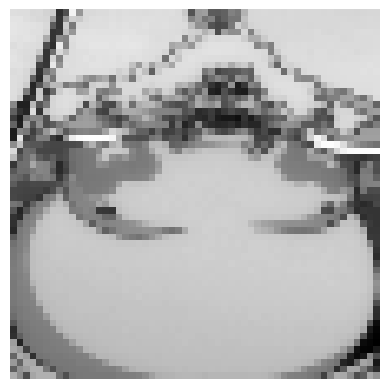

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


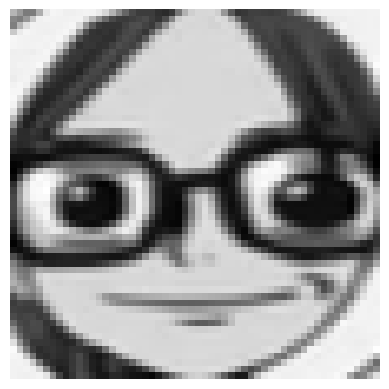

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


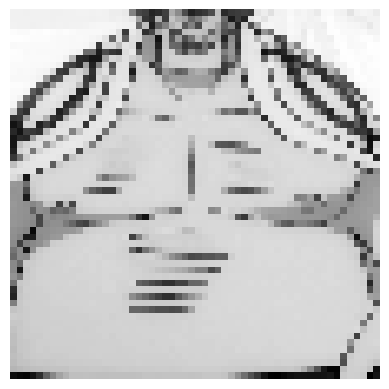

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


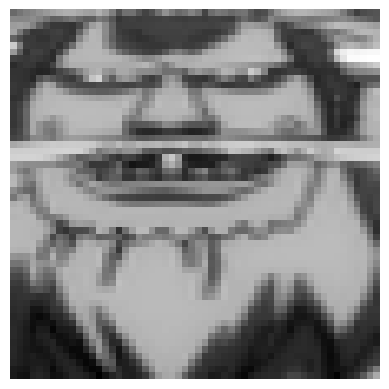

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


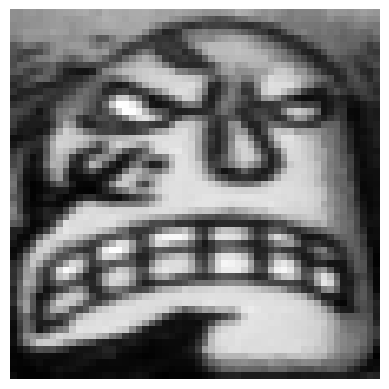

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


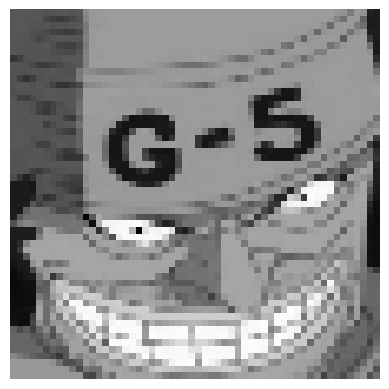

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


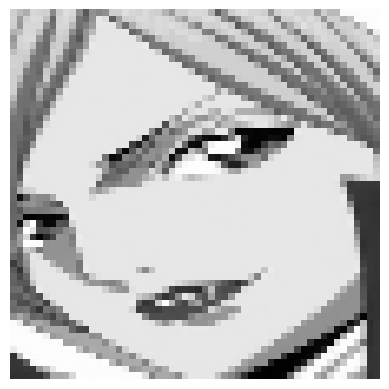

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


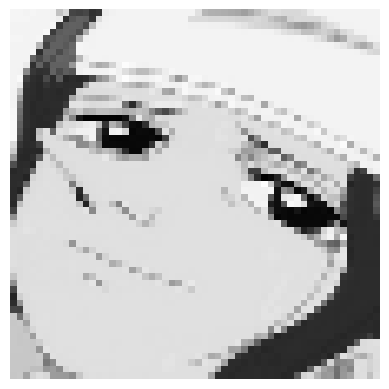

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


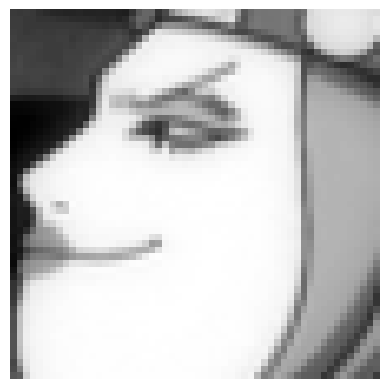

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


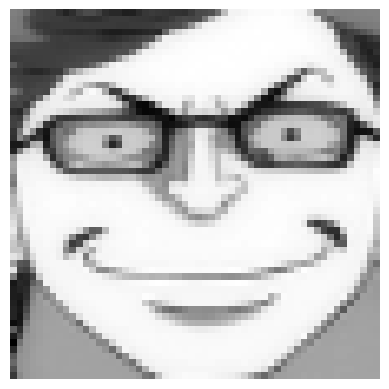

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


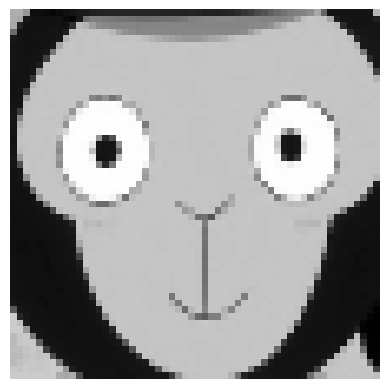

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


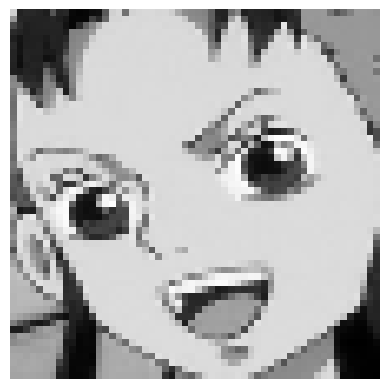

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


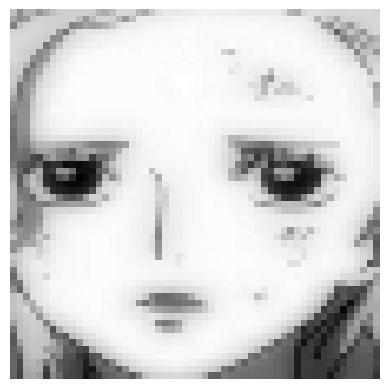

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


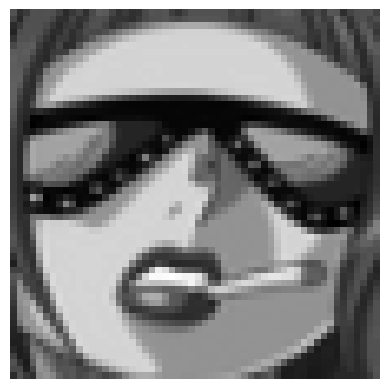

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


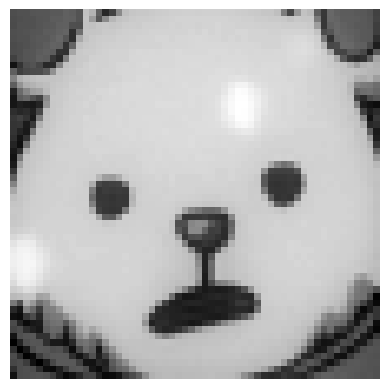

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


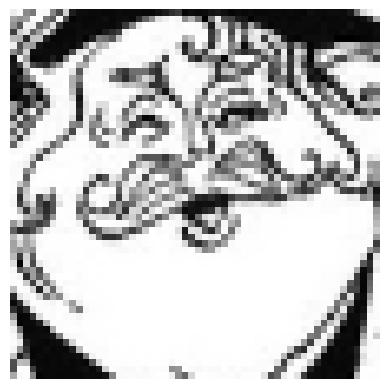

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


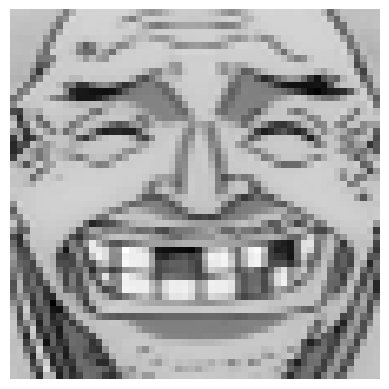

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


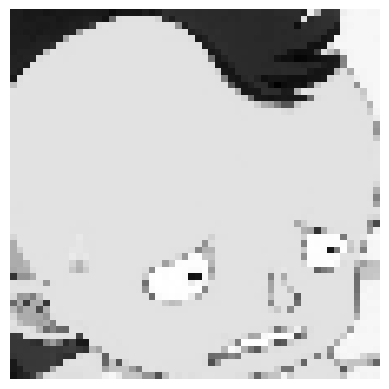

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


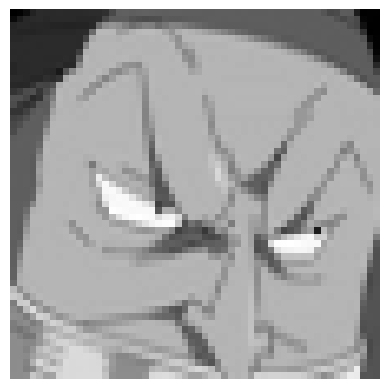

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


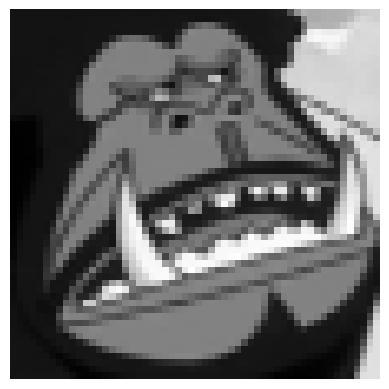

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


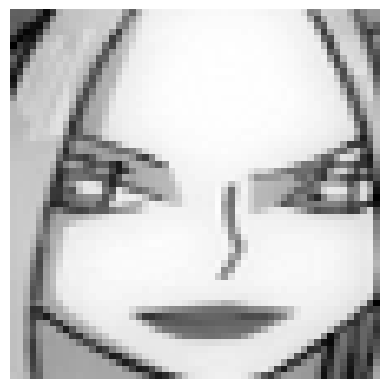

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


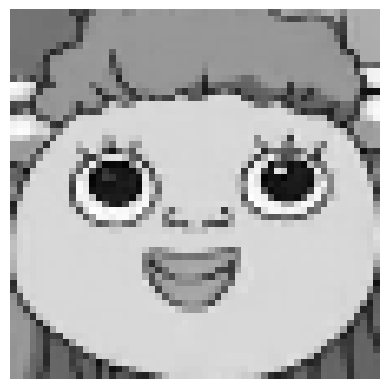

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


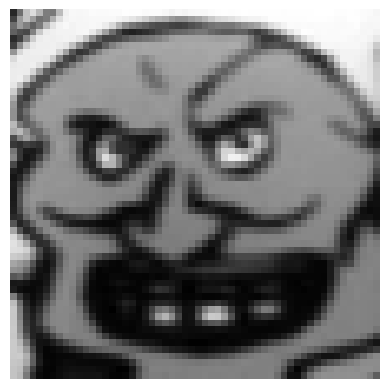

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


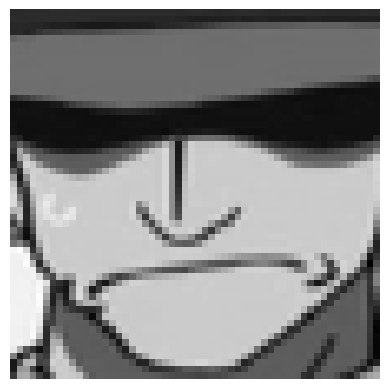

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


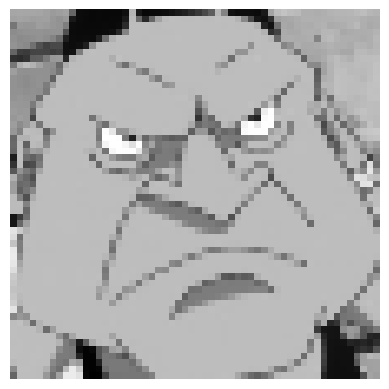

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


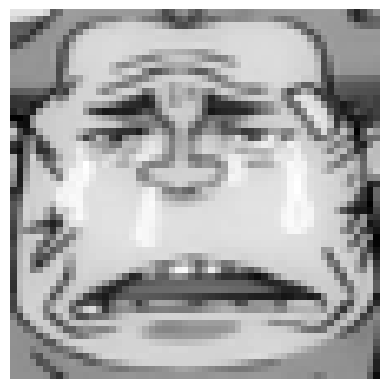

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


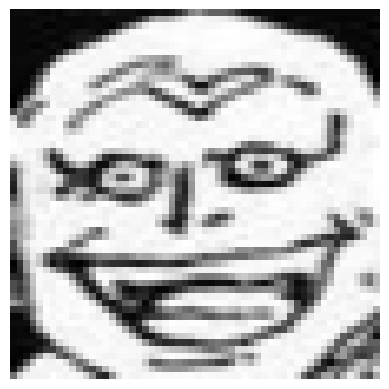

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


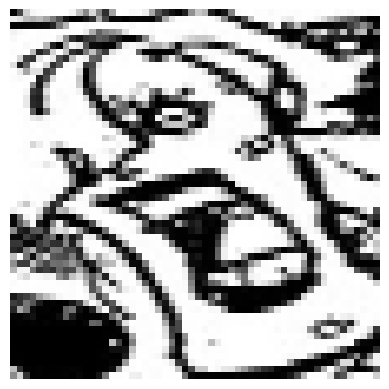

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


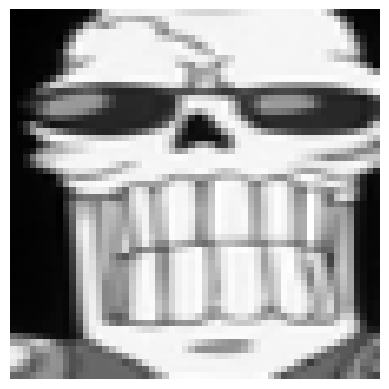

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


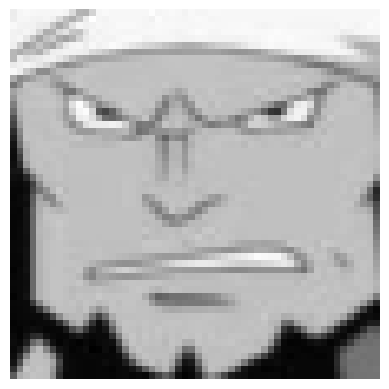

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


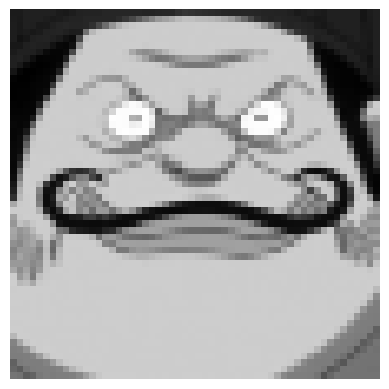

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


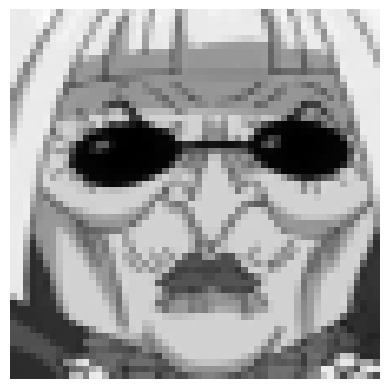

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


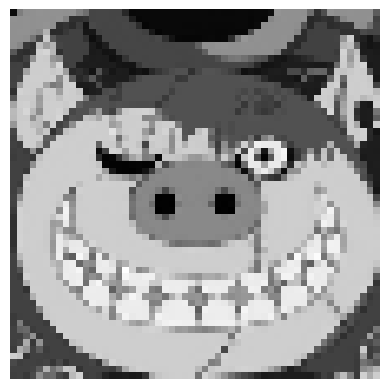

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


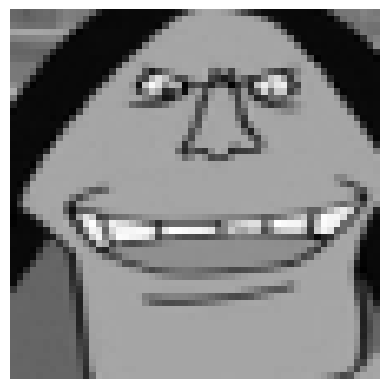

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


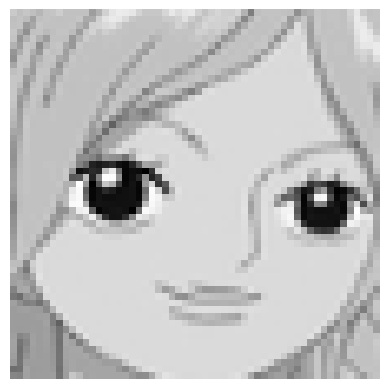

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


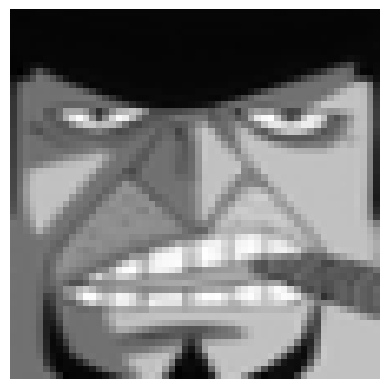

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


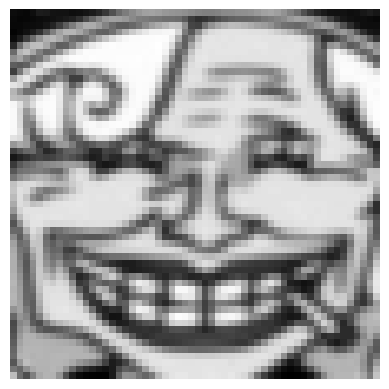

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


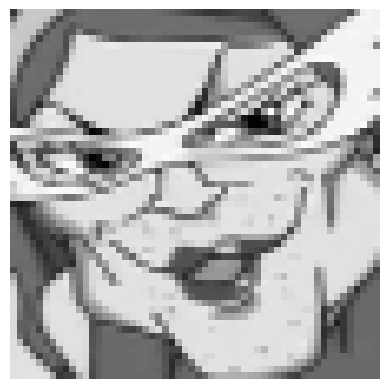

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


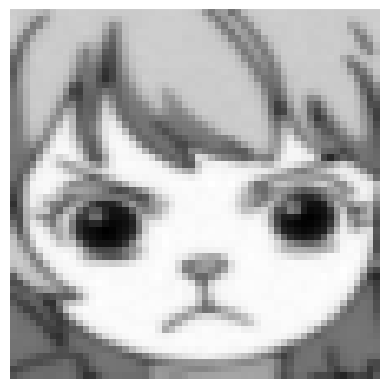

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


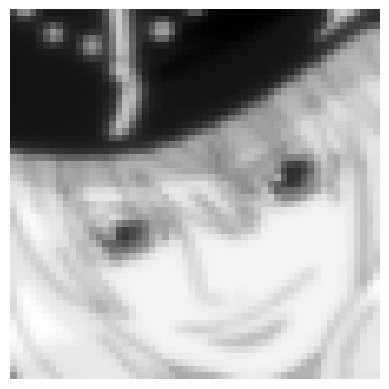

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


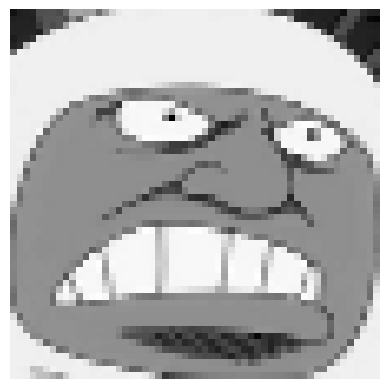

<class 'numpy.ndarray'>
(56, 56, 1)
<class 'list'>


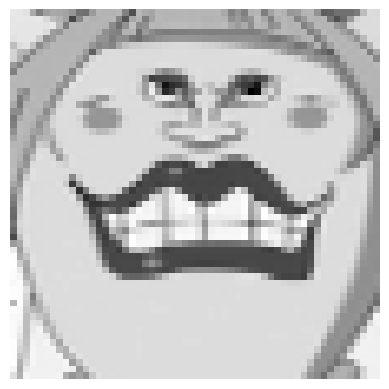

In [ ]:
num_img = 50

for i in range(0, num_img):
  print(type(df_preprocesado[i]))
  print(df_preprocesado[i].shape)
  print(type(df_preprocesado))


  plt.imshow(df_preprocesado[i], cmap='gray')
  plt.axis('off')
  plt.show()

In [ ]:
def generador(dim_latente, canales):

  model = Sequential()

  model.add(Dense(128 * 7 * 7, activation="relu", input_dim=dim_latente))
  model.add(Reshape((7, 7, 128)))
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=3, padding="same"))

  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
  model.add(UpSampling2D())
  model.add(Conv2D(64, kernel_size=3, padding="same"))

  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
  model.add(UpSampling2D())
  model.add(Conv2D(canales, kernel_size=3, padding="same"))

  model.add(Activation("tanh"))

  model.summary()

  ruido = Input(shape=(dim_latente,))
  img = model(ruido)

  return Model(ruido, img)


def discriminador(img_shape):

  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))

  model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  model.summary()

  img = Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

## Instanciacion de los Modelos

In [ ]:
# Compilacion del Discriminador
discriminador = discriminador(df_preprocesado[num_img].shape)

discriminador.compile(loss='binary_crossentropy',
                      optimizer= Adam(0.0002, 0.5), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 zero_padding2d (ZeroPaddin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 15, 15, 64)        256       
 Normalization)                                         

In [ ]:
# Generador
generador = generador(dim_latente=100, canales=1)
# Compimos el Generador creando una img de un ruido añadido
vector_ruido = Input(shape=(100,))
img_generada = generador(vector_ruido)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 14, 14, 128)      

In [ ]:
# El discriminador determina la veracidad de la imagen
resultado = discriminador(img_generada)

In [ ]:
#Creamos la combinacion del Generador y Discriminador
modelo_gen_dis = Model(vector_ruido, resultado)
modelo_gen_dis.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

## TRAINING

In [ ]:
def mostrar_imagen(dim_latente,generator):
    filas = 5
    columnas = 5

    ruido = np.random.normal(0, 1, (filas * columnas,dim_latente))
    gen_imgs = generator.predict(ruido)

    gen_imgs = 0.5 * gen_imgs + 0.5 # Rescalamos las images

    fig, axs = plt.subplots(filas, columnas)
    cnt = 0
    for i in range(filas):
        for j in range(columnas):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

In [ ]:
def entrenamiento_GAN(epochs,
                      df,
                      generator,
                      discriminator,
                      generator_discriminator,
                      batch_size,
                      dim_latente = 100):

  matriz_real = np.ones((batch_size, 1))
  matriz_falso = np.zeros((batch_size, 1))

  for epoch in range(epochs):
    # ---------------------
    #  Entrenaminto Discriminator
    # ---------------------

    # Seleccionamos un conjunto de imagenes
    imagen = df[np.random.randint(0, df.shape[0], batch_size)]

    # Con el ruido creamos un conjunto de nuevas imagenes
    ruido = np.random.normal(0, 1, (batch_size, dim_latente))
    imagen_gen = generator.predict(ruido)

    # Entrenamiento Discriminador
    d_loss_real = discriminator.train_on_batch(imagen, matriz_real) #Entrenamos el bach de la img real
    d_loss_fake = discriminator.train_on_batch(imagen_gen, matriz_falso)  #Entrenamos el bach de la img generada
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Sumamos la los del falso y el real

    # ---------------------
    #  Entrenaminto Generator
    # ---------------------

    # Entrenamiento Combinado Generador Discriminador
    g_loss = generator_discriminator.train_on_batch(ruido, matriz_real)

    # Plot the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    if epoch  % 1000 == 0:
        mostrar_imagen(dim_latente,generator)

In [ ]:
#Añadimos una dimension a nuestro conjunto de datos
df_preprocesado = np.expand_dims(df_preprocesado, axis=3)

In [ ]:
entrenamiento_GAN(epochs = 100000,
                  df = df_preprocesado,
                  generator = generador,
                  discriminator = discriminador,
                  generator_discriminator = modelo_gen_dis,
                  batch_size = len(df_preprocesado),
                  dim_latente = 100)

In [ ]:
def mostrar_imagen(dim_latente, generator):
    filas = 1
    columnas = 5

    ruido = np.random.normal(0, 1, (filas * columnas, dim_latente))
    gen_imgs = generator.predict(ruido)

    # Verificar la forma de las imágenes generadas
    print(f'Forma de gen_imgs: {gen_imgs.shape}')  # Agrega esto para depurar

    # Rescalar las imágenes generadas
    gen_imgs = 0.5 * gen_imgs + 0.5  # Asumiendo que las imágenes están en el rango [-1, 1]

    fig, axs = plt.subplots(filas, columnas, figsize=(15, 3))
    cnt = 0
    for i in range(filas):
        for j in range(columnas):
            # Asegúrate de que las imágenes tengan la forma adecuada para imshow
            if len(gen_imgs[cnt].shape) == 2:  # Si es 2D
                axs[j].imshow(gen_imgs[cnt], cmap='gray')
            else:  # Si es 3D
                axs[j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[j].axis('off')
            cnt += 1
    plt.show()

1/1 [==============================] - 0s 38ms/step
Forma de gen_imgs: (5, 56, 56, 1)


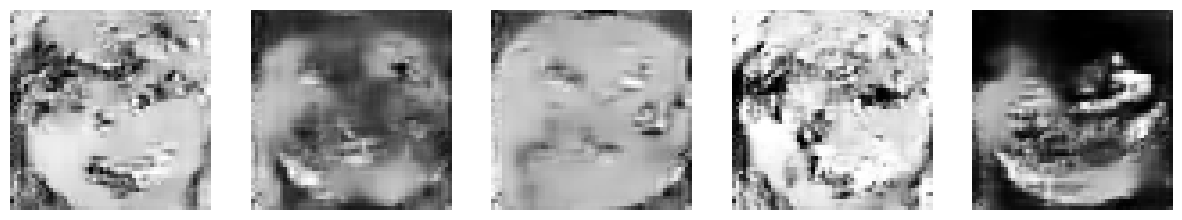

In [ ]:
mostrar_imagen(100,generador)

1/1 [==============================] - 0s 37ms/step


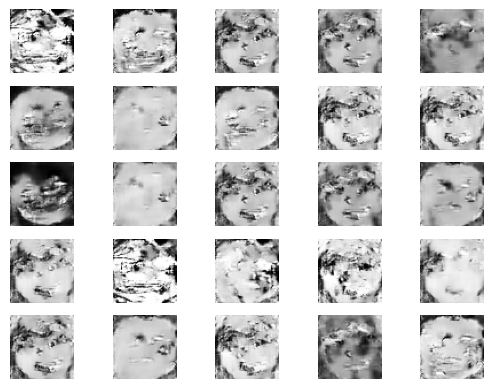

In [ ]:
mostrar_imagen(100,generador)